# ECE1508: Deep Generative Models -- SUM25
## Assignment 3: Implicit Methods for Data Generation
### Programming Part
This assignment reviews implicit generation methods. We mainly focus on the VAE and diffusion models. Our goal os to implement some basic forms of these architectures to get a better understanding.

For each task, some explanations have been given and some starter code has been provided. Please complete the provided code and report your observations and conclusions for each part in the provided markdown. For submission, please pay attention to the instructions. Failure to following the instructions can lead to mark deduction.

Let's start with loading necessary libraries. And defining the `device`.

In [1]:
import torch, torchvision
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST, MNIST
import matplotlib.pyplot as plt
from tqdm import tqdm


import numpy as np
import random
import math

# wired package to solve the kernel crash issue when plotting on jupyter lab and cuda
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# select a device that we want to shift the process on: cuda, cpu, mps
if torch.backends.mps.is_built():
    device = "mps"
elif torch.backends.cuda.is_built():
    device = "cuda"
else:
    device = "cpu"

#print GPU INFO
print(f"GPU: {torch.cuda.get_device_name(device)}")
print(f"Total GPU Memory: {torch.cuda.get_device_properties(device).total_memory / (1024**3):.2f} GB")

GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Total GPU Memory: 8.00 GB


## Programming Question 1: Vector-Quantized VAE

### General Overview
In this assignment, we intend to train a vector-quantized VAE. We discussed this architecture in the course in some detail. In this assignment, we train this model to sample from the `FashionMNIST` dataset. The architecture consists of three components:

* An AE which encodes the data into the latent space and takes it back.
* A Quantizer that quantizes the latent space using a codebook.
* An AR model that learns the latent distribution.

In the sequel, we implement this architecture step by step.

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=32, embedding_dim=64):
        '''
        in_channels is 1 for FashionMNIST
        embedding_dim = number of output channels
        '''
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, embedding_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

Now, we implement the decoder. The suggestion is to reverse the architecture of the encoder. You may use `nn.ConvTranspose2d` if you wish.

In [13]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim=64, hidden_channels=32, out_channels=1):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

### Building the Vector Quantizer
We now write down the VQ block. The quantizer makes a codebook (learnable) of `num_embeddings` codewords each of size `embedding_dim` which is the size of the each output map of the encoder. It then performs the following:

1. takes the output of the encoder and treats each channel of it as a vector $u$
2. finds the codeword that is closest to this vector and replaces it in $z$
3. for training it passes $$z_{\mathrm{train}} = u - \mathrm{sg} (z-u)$$ this provides better gradients
4. computes loss as $$R = \| \mathrm{sg} (z) - u \|^2 + \text{weight} \| \mathrm{sg} (u) - z \|^2 $$ where weight is a number between 0 and 1. This way it provides better gradients for training. You have also seen it in Written Question 4.


In [26]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_loss_weight):
        '''
        num_embeddings = codebook size
        embedding_dim = dimension of each map at latent
        commitment_loss_weight = a weight for combining loss; typically between 0 and 1
        '''
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_loss_weight = commitment_loss_weight

        # Use nn.Embedding to build a codebook
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, u):
        ''''
        u = continuous encoder output, i.e., latent before quantization
        '''

        # Format the shape
        u_perm = u.permute(0, 2, 3, 1).contiguous()

        # Flatten each map into a vector (u_i)
        flat_u = u_perm.view(-1, self.embedding_dim)

        # Compute distances to codebook vectors
        distances = ( 
                    torch.sum(flat_u ** 2, dim=1, keepdim=True)  
                    + torch.sum(self.codebook.weight ** 2, dim=1)
                    - 2 * torch.matmul(flat_u, self.codebook.weight.t())
        )

        # Find nearest codewords
        encoding_indices = torch.argmin(distances, dim=1)

        # Replace the latent with the codeword (discrete latent now)
        z = self.codebook(encoding_indices).view(u_perm.shape)

        # Convert back to original shape
        z = z.permute(0, 3, 1, 2).contiguous()

        # For training we use the "straight-through estimator"
        # This provides us better gradients
        z_train = u + (z - u).detach()

        # Losses
        codebook_loss = F.mse_loss(z.detach(), u)
        commitment_loss = F.mse_loss(z, u.detach())

        # combine the two losses using self.commitment_loss_weight
        loss = codebook_loss + self.commitment_loss_weight * commitment_loss

        return {
            'u': u,                    # real-valued encoder output
            'z': z_train,              # quantized version + error used by decoder during training
            'vq_loss': loss,           # VQ loss
            'encoding_indices': encoding_indices.view(u.shape[0], u.shape[2], u.shape[3])
        }

### Training Loop VQ-VAE
We now train this architecture:
$$
\text{Input} \rightarrow \text{Encoder} \rightarrow u \rightarrow \text{VQ} \rightarrow z \rightarrow \text{Decoder} \rightarrow \text{Input Recovery}
$$

We first write the `train_VQVAE` function which takes the components and trains the AE. Note that the loss in this case, is the summation of the quantization and reconstruction losses.

In [25]:
def train_VQVAE(encoder, decoder, vq_layer, num_epochs, train_loader, optimizer):
    for epoch in range(num_epochs):

        # put to train mode
        encoder.train()
        decoder.train()
        vq_layer.train()

        # initiate variables
        total_loss = 0
        recon_loss_total = 0
        vq_loss_total = 0

        # train loop
        for images, _ in train_loader:

            images = images.to(device) #send to device

            # Encode
            u = encoder(images)

            # Vector quantization
            vq_out = vq_layer(u)

            # take the quantized output
            z = vq_out['z']

            # compute quantization loss
            vq_loss =vq_out['vq_loss']

            # Decode
            x_recon = decoder(z)

            # Compute reconstruction loss
            recon_loss = F.mse_loss(x_recon, images)

            # Add quantization loss to reconstruction loss
            loss = recon_loss + vq_loss

            # Backpropagate and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update losses
            total_loss += loss.item()
            recon_loss_total += recon_loss.item()
            vq_loss_total += vq_loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}]  "
            f"Total Loss: {total_loss:.3f}  "
            f"Reconstruction Loss: {recon_loss_total:.3f}  "
            f"Quantization Loss: {vq_loss_total:.3f}")

### Load Data and Train
We now instantiate data and model

In [66]:
# set the dimensions and weights
embedding_dim = 64
num_embeddings = 128
commitment_cost = 0.25
lr = 1e-3
num_epochs = 20

# We load Fashion MNIST
# We perform some required transform
transform = transforms.ToTensor()
# We then load the dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
# and build a train loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Instantiate an encoder, VQ and decoder and move them to device
encoder = Encoder().to(device)
vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost).to(device)
decoder = Decoder().to(device)

# list the parameters and pass them to Adam optimizer
params = list(encoder.parameters()) + list(vq_layer.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

and train

In [67]:
# COMPLETE using train_VQVAE
train_VQVAE(encoder, decoder, vq_layer, num_epochs, train_loader, optimizer)

Epoch [1/20]  Total Loss: 42.243  Reconstruction Loss: 19.695  Quantization Loss: 22.548
Epoch [2/20]  Total Loss: 7.794  Reconstruction Loss: 5.228  Quantization Loss: 2.566
Epoch [3/20]  Total Loss: 8.008  Reconstruction Loss: 4.799  Quantization Loss: 3.209
Epoch [4/20]  Total Loss: 7.895  Reconstruction Loss: 4.475  Quantization Loss: 3.419
Epoch [5/20]  Total Loss: 7.864  Reconstruction Loss: 4.265  Quantization Loss: 3.599
Epoch [6/20]  Total Loss: 7.847  Reconstruction Loss: 4.132  Quantization Loss: 3.715
Epoch [7/20]  Total Loss: 7.822  Reconstruction Loss: 4.040  Quantization Loss: 3.781
Epoch [8/20]  Total Loss: 7.825  Reconstruction Loss: 3.973  Quantization Loss: 3.852
Epoch [9/20]  Total Loss: 7.860  Reconstruction Loss: 3.932  Quantization Loss: 3.928
Epoch [10/20]  Total Loss: 7.898  Reconstruction Loss: 3.903  Quantization Loss: 3.995
Epoch [11/20]  Total Loss: 7.930  Reconstruction Loss: 3.884  Quantization Loss: 4.047
Epoch [12/20]  Total Loss: 7.941  Reconstruction 

### Check Reconstruction
Let us now take a look at reconstruction.

In [68]:
def show_reconstructions(loader):
    encoder.eval()
    decoder.eval()
    vq_layer.eval()

    with torch.no_grad():
        test_imgs, _ = next(iter(loader))
        test_imgs = test_imgs.to(device)

        # Now encode, quantize and decode
        z = vq_layer(encoder(test_imgs))['z']
        x_recon = decoder(z)

        imgs = torch.cat([test_imgs, x_recon], dim=0).cpu()

        fig, axes = plt.subplots(2, 8, figsize=(12, 3))
        for i in range(8):
            axes[0, i].imshow(imgs[i][0], cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(imgs[i+8][0], cmap='gray')
            axes[1, i].axis('off')
        axes[0, 0].set_ylabel("Original")
        axes[1, 0].set_ylabel("Reconstruction")
        plt.tight_layout()
        plt.show()

Let's take a look then

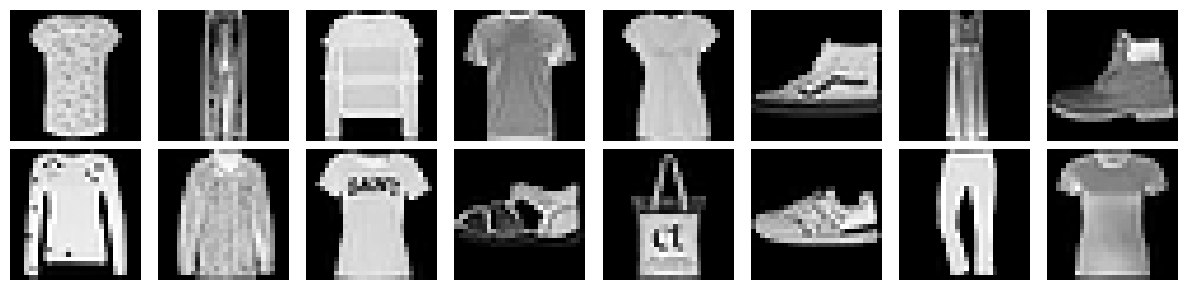

In [79]:
# COMPLETE using show_reconstructions
show_reconstructions(train_loader)

### Question: _What do you observe? Do we really do Variational AE?_


*   the re-constructed imags is somehow matched our expectation are some are very similar to image that generats them while some are mis-matched, we can see that the VQ-VAE could capture essntial structure of these classes of image yet some details are not what captured.
*   We dont need to do variational AE as we are using VQ-VAE as even thogh the name conatins VAE, its latent space is using discrete codeblock compare to the continuous gaussian, and it is sampling from Nearest-neighbor lookup in codebook compared to sampled from continuous distribution.They are two different concept.



### Learning Latent Distribution
To learn the latent distribution, we use PixelCNN. Since we already have implemented this architecture, the code is given here, and you may directly use it. Feel free to modify it if you wish.

In [85]:
# This is a masked Convolution <No need to Complete>
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, mask_type='A', **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, padding=kernel_size//2, **kwargs)
        self.register_buffer("mask", torch.ones_like(self.weight))

        yc, xc = kernel_size // 2, kernel_size // 2

        self.mask[:, :, yc+1:, :] = 0
        self.mask[:, :, yc, xc+1:] = 0
        if mask_type == 'A':
            self.mask[:, :, yc, xc] = 0  # zero center for first layer

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

# and this is a simple PixelCNN <No need to Complete>

class PixelCNN(nn.Module):
    def __init__(self, num_embeddings, hidden_channels=64, n_layers=7):
        super().__init__()
        layers = []
        layers.append(MaskedConv2d(1, hidden_channels, kernel_size=7, mask_type='A'))

        for _ in range(n_layers - 2):
            layers.append(MaskedConv2d(hidden_channels, hidden_channels, kernel_size=3, mask_type='B'))
            layers.append(nn.ReLU())

        layers.append(nn.Conv2d(hidden_channels, num_embeddings, kernel_size=1))  # logits
        self.net = nn.Sequential(*layers)

    def forward(self, x):  # x: (B, 1, H, W) of integer indices
        return self.net(x)


We now train this pixelCNN to learn the latent distribution. To this end, we first write a function that takes the dataloader and returns the quantized latent representation of them. This will build our dataset on which we train the PixelCNN.

In [86]:
def encode_dataset(encoder, vq_layer, dataloader):
    all_indices = []
    encoder.eval()
    vq_layer.eval()

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            indices =  vq_layer(encoder(x))['encoding_indices']

            # append the quantization
            all_indices.append(indices)

    # Concatenate to get full size
    all_indices = torch.cat(all_indices, dim=0)

    # Add channel dimension
    all_indices = all_indices.unsqueeze(1)

    return TensorDataset(all_indices)

We next write a training loop for PixelCNN which trains the PixelCNN on the encoded dataset.

In [87]:
def train_PixelCNN(pixelcnn, optimizer, index_loader, num_epochs):
    '''
    index_loader = encoded dataset
    '''
    for epoch in range(num_epochs):
        pixelcnn.train()
        total_loss = 0

        for (indices,) in index_loader:
            indices = indices.to(device)
            loss = F.cross_entropy(pixelcnn(indices.float()), indices.squeeze(1).long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"PixelCNN Epoch {epoch+1}, Loss: {total_loss:.4f}")

Now let's instantiate and train.

In [88]:
# # Model and optimizer
pixelcnn = PixelCNN(num_embeddings=num_embeddings).to(device)
optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=1e-3)

# encoded dataset
index_dataset = encode_dataset(encoder, vq_layer, train_loader)
index_loader = DataLoader(index_dataset, batch_size=64, shuffle=True)

# etc
num_epochs = 60

train_PixelCNN(pixelcnn, optimizer, index_loader, num_epochs)


PixelCNN Epoch 1, Loss: 2196.3741
PixelCNN Epoch 2, Loss: 1818.3476
PixelCNN Epoch 3, Loss: 1711.1647
PixelCNN Epoch 4, Loss: 1649.2234
PixelCNN Epoch 5, Loss: 1610.4342
PixelCNN Epoch 6, Loss: 1580.1107
PixelCNN Epoch 7, Loss: 1557.8363
PixelCNN Epoch 8, Loss: 1536.7354
PixelCNN Epoch 9, Loss: 1521.0569
PixelCNN Epoch 10, Loss: 1506.8037
PixelCNN Epoch 11, Loss: 1493.9964
PixelCNN Epoch 12, Loss: 1482.1375
PixelCNN Epoch 13, Loss: 1473.4608
PixelCNN Epoch 14, Loss: 1467.4890
PixelCNN Epoch 15, Loss: 1455.7018
PixelCNN Epoch 16, Loss: 1451.7007
PixelCNN Epoch 17, Loss: 1443.9935
PixelCNN Epoch 18, Loss: 1436.1771
PixelCNN Epoch 19, Loss: 1433.4290
PixelCNN Epoch 20, Loss: 1427.0055
PixelCNN Epoch 21, Loss: 1425.1089
PixelCNN Epoch 22, Loss: 1418.8331
PixelCNN Epoch 23, Loss: 1413.0743
PixelCNN Epoch 24, Loss: 1408.6180
PixelCNN Epoch 25, Loss: 1407.9888
PixelCNN Epoch 26, Loss: 1402.8988
PixelCNN Epoch 27, Loss: 1399.5977
PixelCNN Epoch 28, Loss: 1396.4154
PixelCNN Epoch 29, Loss: 1394

### Sampling Latent
We now write a simple function to sample from the latent distribution using our trained AR model.

In [89]:
def sample_pixelcnn(pixelcnn, shape, temperature=1.0):
    '''
    shape = the desired shape that matches the decoder input
    temperature = for Softmax while sampling
    '''
    pixelcnn.eval()
    samples = torch.zeros(shape, dtype=torch.long).to(device)

    with torch.no_grad():
        # write the AR sampling
        for i in range(shape[2]):
            for j in range(shape[3]):
                logits = pixelcnn(samples.float())
                probs = torch.softmax(logits[:, :, i, j] / temperature, dim=-1)
                samples[:, 0, i, j] = torch.multinomial(probs, num_samples=1).squeeze(-1)

    return samples


We also write a decoding function which uses the trained decoder to decode a latent sample.

In [90]:
def decode_indices(samples, vq_layer, decoder):
    # take corresponding codewords from the codebook
    codewords = vq_layer.codebook(samples.view(-1)).view(samples.shape[0], samples.shape[2], samples.shape[3], -1)
    # put it in the right shape
    z = codewords.permute(0, 3, 1, 2).contiguous()
    return decoder(z)

### Generation
We now sample the latent via the AR model and look at the decoded version.

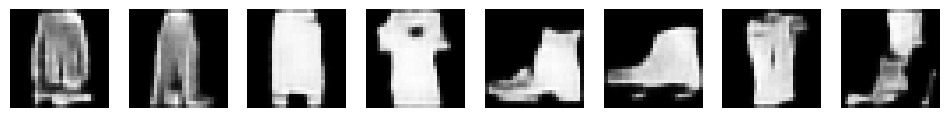

In [98]:
# sample 8 latent samples and decode
samples = sample_pixelcnn(pixelcnn, shape=(8, 1, 7, 7), temperature=1.0)
decoded_imgs = decode_indices(samples, vq_layer, decoder)

# visualize
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(decoded_imgs[i][0].detach().cpu().numpy(), cmap='gray') #some workaround
    axes[i].axis('off')
plt.show()


### Question: _How is the quality? Does it match your expectation? How can we improve the quality?_
*  We can see that most of the generated image looks coase but recognizable as we can vaguely distinguish between shirt shoes
*   This is the expected behaviour
*   We could improve the quality by training for more epoches, or imporve the model with more/sufficient layers and channels and have a higer resolution latent map for more details and better re-construction quality



## Programming Question 2: Diffusion Score Matching
In this assignment we try to build the simplest possible diffusion model and train it on the subset of MNIST dataset that include only digit 8. The main purpose is to review what we have learned about diffusion and its connection to data generation. Our model consists of a simple score network which is trained using the diffusion score matching idea: _add noise to samples and estimate their score using the noise term._ We train this network on MNIST and then use it to generate samples by a simple reverse SDE.

### Building the Score Net
Our score net is a basic CNN with 8 layers. The number of channels change in the following order
$$
1 (\text{MNIST}) \mapsto 32 \mapsto 64 \mapsto 128 \mapsto 256 \mapsto 128 \mapsto 64 \mapsto 32 \mapsto 1
$$
each layer uses batch normalization. We activate each layer by $\mathrm{SiLU}$ function.

To include the noise standard deviation $\sigma$, we use the following trick: we first embed the noise standard deviation via the following positional encoding:
1. choose an even embedding dimension $d$
2. for $i = 0,1,\ldots, d/2-1$ find the following frequencies
$$
\omega_i = 10000^{- \frac{i}{d/2-1} }
$$
3. compute the following embedding vector
$$
\bold{e} (\sigma) = [ \sin (\omega_0 \log \sigma ), \sin (\omega_1 \log \sigma ), \ldots, \sin (\omega_{d/2-1} \log \sigma ),
\cos (\omega_0 \log \sigma ), \cos (\omega_1\log \sigma ), \ldots, \cos (\omega_{d/2-1} \log \sigma )
]
$$

Then, in each convolutional layer, we add the impact of noise standard deviation by projecting its embedding $\bold{e} (\sigma)$ via a linear layer and adding it to the output of convolution _after batch normalization_ and _before activation._ The following code implement this score net.

In [21]:
class ScoreNet(nn.Module):
    def __init__(self, embed_dim=32):
        '''
        embed_dim = size of noise embedding
        '''
        super().__init__()

        self.embed_dim = embed_dim

        # Convolutional layers with BatchNorm
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.Conv2d(32, 1, 3, padding=1),
        )

        # Noise conditioning layers
        self.noise_mlp = nn.Linear(embed_dim, 1)
        self.act = nn.SiLU()

    def _get_embedding(self, log_sigma, embedding_dim):
        half_dim = embedding_dim // 2

        # compute frequencies omega
        emb = torch.arange(half_dim, dtype=log_sigma.dtype, device=log_sigma.device)
        emb = 10000 ** (-emb / half_dim)
        
        # get the positional encoding
        emb = log_sigma[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

        return emb

    def forward(self, x, sigma):
        B, C, H, W = x.shape

        # embed the noise
        log_sigma = torch.log(sigma.clamp(min=1e-8)).view(B)
        noise_emb = self._get_embedding(log_sigma, self.embed_dim)

        # pass through conv and normalize
        output = self.net(x) + self.noise_mlp(noise_emb).view(B, 1, 1, 1)
        output = self.act(output)
        return output

### Defining DSM Loss
We next define the loss of diffusion score matching. Here, we consider direct estimation of the score given by the noise term.

In [6]:
def dsm_loss(score_net, x, device, sigma_min=1e-6, sigma_max=1.0):
    '''
    sigma_min and sigma_max are the range of sigma we train the score net on
    '''
    B = x.shape[0]

    # Sample random noise levels
    log_sigma = torch.rand(B, 1, 1, 1, device=device) * \
        (np.log(sigma_max) - np.log(sigma_min)) + np.log(sigma_min)
    sigma = torch.exp(log_sigma)

    # Add noise
    noise = torch.randn_like(x)
    x_noisy = x + sigma * noise

    # Predict score by Score Net
    score_pred = score_net(x_noisy, sigma)

    # Find the score estimate from noise
    target = -noise / sigma

    # for training stability, we scale thr loss with sigma^2
    weights = sigma ** 2
    loss = torch.mean(weights * (score_pred - target) ** 2)

    return loss


### Sampling Diffusion Process
We now sample the diffusion trajectory. In this trajectory, we consider the forward SDE as
$$
\mathrm{d} x_t = -\frac{1}{2} \beta_t \mathrm{d} t + \sqrt{\beta_t} \mathrm{d} B_t
$$
where here $\beta_t$ is a function of time. We consider a simple linear function:
$$
\beta_t = \beta_{\min} + (\beta_{\max}- \beta_{\min}) t
$$
for some minimum and maximum choice of $\beta$.

Note that we use the __reverse SDE__ to sample from data distribution. In our implementation, we approximate the eduation by breaking the time interval $t\in [10^{-6}, 1]$ into 1000 time steps, i.e., $\mathrm{d} t \approx 0.001$. You can increase the accuracy as you wish.


### Question: _Write down the reverse SDE._
COMPLETE
__Hint:__ When you build the reverse SDE pay attention to the sign of time difference $\mathrm{d} t$ when multiplied by drift term.

In [10]:
# write the beta function
def beta_schedule(t, beta_min=0.1, beta_max=10.0):
    # Linearly increasing beta(t)
    return beta_min + t * (beta_max - beta_min)


# write sampling function
@torch.no_grad()
def sample_from_model(score_net, shape, device, num_steps=1000):
    score_net.eval()

    # sample noise
    x = torch.randn(shape, device=device)

    # specify time steps backward 1 -> 0
    t_steps = torch.linspace(1., 1e-3, num_steps, device=device)

    # start the trajectory
    for i in range(num_steps - 1):
        # time steps and dt
        t = t_steps[i]
        dt = t - t_steps[i+1]

        # find beta_t
        beta_t = beta_schedule(t)

        # compute noise standard deviation and give it along with x to score net for denoising
        sigma = torch.sqrt(beta_t)
        sd_tensor = torch.full((shape[0], 1, 1, 1), sigma.item(), device=device)
        score = score_net(x, sd_tensor)

        # use score to compute drift and diffusion coefficient of the reverse SDE
        drift = -0.5 * beta_t * x - beta_t * score
        diffusion = torch.sqrt(beta_t)

        # write the reverse SDE
        x = x + drift * dt + diffusion * torch.sqrt(dt) * torch.randn_like(x)

        if (i+1) % 200 == 0 or i==0:
            print(f" Step {i+1}/{num_steps}, t={t:.4f}, noise SD={sigma:.2f}")

    return x

### Training DSM
We now train our score model on digit 8 images in MNIST. Let us first write the train function.

In [13]:
def train_score_model(model, train_loader, device, num_epochs = 100):

    # Optimizer: for simplicity included in the function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)


    # Let's visualize the output every couple of epochs
    sample_interval = 10
    losses = []

    # training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        # for visualization
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        # batch computations visualized
        for _, (data, _) in enumerate(pbar):
            data = data.to(device)

            # Compute DSM loss
            loss = dsm_loss(model, data, device)

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # schedule the learning rate
        scheduler.step()

        # Log epoch results
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}: Loss = {avg_loss:.4f}, LR = {scheduler.get_last_lr()[0]:.6f}')

        # Generate samples every couple of epochs
        if (epoch + 1) % sample_interval == 0:
            print("Generating samples...")
            model.eval()

            # sample a batch of 6 images
            samples = sample_from_model(model, (6, 1, 28, 28), device)

            # Normalize samples based on data range
            samples = (samples - samples.min()) / (samples.max() - samples.min() + 1e-8)

            # Plot samples
            fig, axes = plt.subplots(1, 6, figsize=(12,2))
            for i, ax in enumerate(axes.flat):
                ax.imshow(samples[i, 0].cpu().numpy(), cmap='gray')
                ax.axis('off')
            plt.suptitle(f'Generated Samples - Epoch {epoch+1} (Loss: {avg_loss:.3f})')
            plt.tight_layout()
            plt.show()

        # Save checkpoint if you like
        if (epoch + 1) % 50 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'losses': losses
            }
            torch.save(checkpoint, f'dsm_model_epoch_{epoch+1}.pt')
            print(f"Checkpoint saved: dsm_model_epoch_{epoch+1}.pt")

    # Final training curve
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('DSM Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    return model, losses

### Train on MNIST
We now train it on MNIST and look at the result. First we instantiate the model and prepare dataloader.

In [16]:
# Load MNIST
full_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Find indices of digit 8
digit_8_indices = [i for i, (_, label) in enumerate(full_dataset) if label == 8]

# Create dataset
train_dataset = Subset(full_dataset, digit_8_indices)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

model = ScoreNet().to(device)
num_epochs = 100


100%|██████████| 9.91M/9.91M [00:00<00:00, 10.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 7.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


and now we train

Epoch 1/100: 100%|██████████| 46/46 [00:08<00:00,  5.52it/s, loss=0.9262]


Epoch 1: Loss = 0.9531, LR = 0.000100


Epoch 2/100: 100%|██████████| 46/46 [00:06<00:00,  6.59it/s, loss=0.8947]


Epoch 2: Loss = 0.9199, LR = 0.000100


Epoch 3/100: 100%|██████████| 46/46 [00:07<00:00,  6.35it/s, loss=0.9121]


Epoch 3: Loss = 0.9098, LR = 0.000100


Epoch 4/100: 100%|██████████| 46/46 [00:07<00:00,  6.36it/s, loss=0.9211]


Epoch 4: Loss = 0.9067, LR = 0.000100


Epoch 5/100: 100%|██████████| 46/46 [00:07<00:00,  6.46it/s, loss=0.8931]


Epoch 5: Loss = 0.8981, LR = 0.000099


Epoch 6/100: 100%|██████████| 46/46 [00:07<00:00,  6.54it/s, loss=0.8893]


Epoch 6: Loss = 0.8930, LR = 0.000099


Epoch 7/100: 100%|██████████| 46/46 [00:07<00:00,  6.35it/s, loss=0.8541]


Epoch 7: Loss = 0.8910, LR = 0.000099


Epoch 8/100: 100%|██████████| 46/46 [00:07<00:00,  6.50it/s, loss=0.8853]


Epoch 8: Loss = 0.8906, LR = 0.000098


Epoch 9/100: 100%|██████████| 46/46 [00:07<00:00,  6.52it/s, loss=0.8866]


Epoch 9: Loss = 0.8843, LR = 0.000098


Epoch 10/100: 100%|██████████| 46/46 [00:07<00:00,  6.43it/s, loss=0.8972]


Epoch 10: Loss = 0.8800, LR = 0.000098
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16
 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


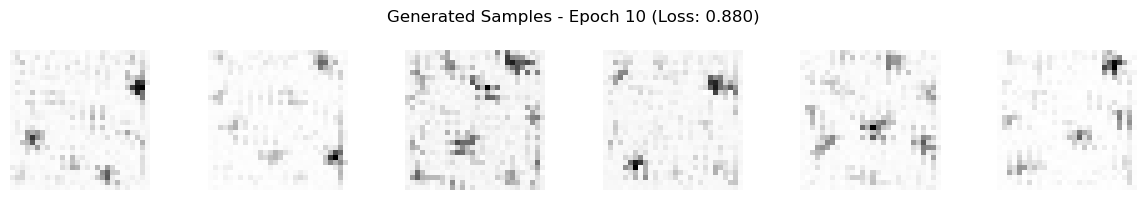

Epoch 11/100: 100%|██████████| 46/46 [00:07<00:00,  6.08it/s, loss=0.9050]


Epoch 11: Loss = 0.8806, LR = 0.000097


Epoch 12/100: 100%|██████████| 46/46 [00:09<00:00,  4.83it/s, loss=0.8734]


Epoch 12: Loss = 0.8840, LR = 0.000097


Epoch 13/100: 100%|██████████| 46/46 [00:13<00:00,  3.54it/s, loss=0.8837]


Epoch 13: Loss = 0.8790, LR = 0.000096


Epoch 14/100: 100%|██████████| 46/46 [00:07<00:00,  5.90it/s, loss=0.8538]


Epoch 14: Loss = 0.8758, LR = 0.000095


Epoch 15/100: 100%|██████████| 46/46 [00:07<00:00,  5.99it/s, loss=0.8808]


Epoch 15: Loss = 0.8710, LR = 0.000095


Epoch 16/100: 100%|██████████| 46/46 [00:07<00:00,  6.20it/s, loss=0.9117]


Epoch 16: Loss = 0.8724, LR = 0.000094


Epoch 17/100: 100%|██████████| 46/46 [00:07<00:00,  6.04it/s, loss=0.8747]


Epoch 17: Loss = 0.8749, LR = 0.000093


Epoch 18/100: 100%|██████████| 46/46 [00:07<00:00,  6.23it/s, loss=0.8799]


Epoch 18: Loss = 0.8721, LR = 0.000092


Epoch 19/100: 100%|██████████| 46/46 [00:07<00:00,  6.07it/s, loss=0.8772]


Epoch 19: Loss = 0.8745, LR = 0.000091


Epoch 20/100: 100%|██████████| 46/46 [00:07<00:00,  6.14it/s, loss=0.8473]


Epoch 20: Loss = 0.8675, LR = 0.000091
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16
 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


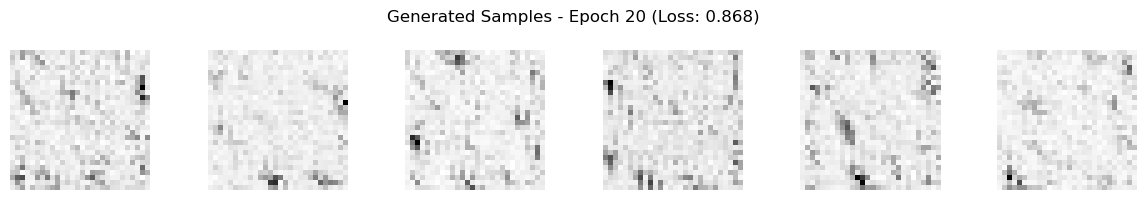

Epoch 21/100: 100%|██████████| 46/46 [00:06<00:00,  6.58it/s, loss=0.8450]


Epoch 21: Loss = 0.8645, LR = 0.000090


Epoch 22/100: 100%|██████████| 46/46 [00:06<00:00,  6.59it/s, loss=0.8770]


Epoch 22: Loss = 0.8644, LR = 0.000089


Epoch 23/100: 100%|██████████| 46/46 [00:07<00:00,  6.43it/s, loss=0.8743]


Epoch 23: Loss = 0.8649, LR = 0.000088


Epoch 24/100: 100%|██████████| 46/46 [00:06<00:00,  6.62it/s, loss=0.8360]


Epoch 24: Loss = 0.8597, LR = 0.000087


Epoch 25/100: 100%|██████████| 46/46 [00:07<00:00,  6.51it/s, loss=0.8553]


Epoch 25: Loss = 0.8584, LR = 0.000086


Epoch 26/100: 100%|██████████| 46/46 [00:06<00:00,  6.78it/s, loss=0.8786]


Epoch 26: Loss = 0.8601, LR = 0.000084


Epoch 27/100: 100%|██████████| 46/46 [00:07<00:00,  6.50it/s, loss=0.8350]


Epoch 27: Loss = 0.8595, LR = 0.000083


Epoch 28/100: 100%|██████████| 46/46 [00:07<00:00,  6.16it/s, loss=0.8503]


Epoch 28: Loss = 0.8620, LR = 0.000082


Epoch 29/100: 100%|██████████| 46/46 [00:07<00:00,  6.10it/s, loss=0.8804]


Epoch 29: Loss = 0.8644, LR = 0.000081


Epoch 30/100: 100%|██████████| 46/46 [00:07<00:00,  5.91it/s, loss=0.8785]


Epoch 30: Loss = 0.8606, LR = 0.000080
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16
 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


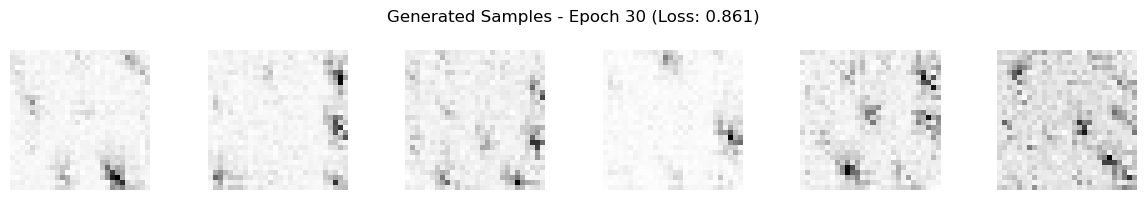

Epoch 31/100: 100%|██████████| 46/46 [00:07<00:00,  6.06it/s, loss=0.8540]


Epoch 31: Loss = 0.8601, LR = 0.000078


Epoch 32/100: 100%|██████████| 46/46 [00:07<00:00,  6.28it/s, loss=0.8437]


Epoch 32: Loss = 0.8607, LR = 0.000077


Epoch 33/100: 100%|██████████| 46/46 [00:07<00:00,  6.15it/s, loss=0.8558]


Epoch 33: Loss = 0.8604, LR = 0.000076


Epoch 34/100: 100%|██████████| 46/46 [00:07<00:00,  6.12it/s, loss=0.8569]


Epoch 34: Loss = 0.8573, LR = 0.000074


Epoch 35/100: 100%|██████████| 46/46 [00:07<00:00,  6.10it/s, loss=0.8415]


Epoch 35: Loss = 0.8589, LR = 0.000073


Epoch 36/100: 100%|██████████| 46/46 [00:07<00:00,  6.06it/s, loss=0.8858]


Epoch 36: Loss = 0.8586, LR = 0.000072


Epoch 37/100: 100%|██████████| 46/46 [00:07<00:00,  5.79it/s, loss=0.8648]


Epoch 37: Loss = 0.8595, LR = 0.000070


Epoch 38/100: 100%|██████████| 46/46 [00:07<00:00,  6.12it/s, loss=0.8688]


Epoch 38: Loss = 0.8518, LR = 0.000069


Epoch 39/100: 100%|██████████| 46/46 [00:07<00:00,  6.13it/s, loss=0.8656]


Epoch 39: Loss = 0.8529, LR = 0.000067


Epoch 40/100: 100%|██████████| 46/46 [00:07<00:00,  6.17it/s, loss=0.8690]


Epoch 40: Loss = 0.8549, LR = 0.000066
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16
 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


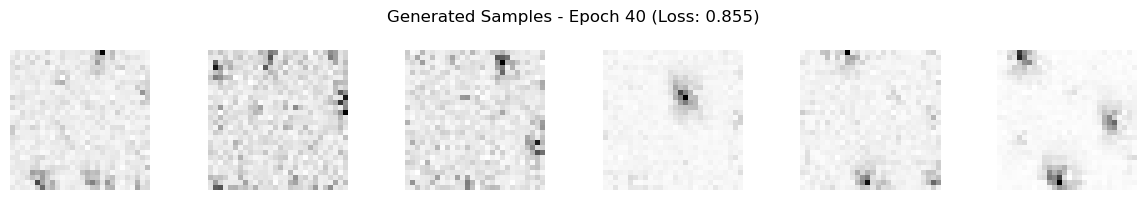

Epoch 41/100: 100%|██████████| 46/46 [00:07<00:00,  6.31it/s, loss=0.8482]


Epoch 41: Loss = 0.8546, LR = 0.000064


Epoch 42/100: 100%|██████████| 46/46 [00:07<00:00,  6.31it/s, loss=0.8498]


Epoch 42: Loss = 0.8511, LR = 0.000063


Epoch 43/100: 100%|██████████| 46/46 [00:07<00:00,  6.48it/s, loss=0.8353]


Epoch 43: Loss = 0.8467, LR = 0.000061


Epoch 44/100: 100%|██████████| 46/46 [00:07<00:00,  6.29it/s, loss=0.8728]


Epoch 44: Loss = 0.8533, LR = 0.000060


Epoch 45/100: 100%|██████████| 46/46 [00:07<00:00,  6.53it/s, loss=0.8739]


Epoch 45: Loss = 0.8506, LR = 0.000058


Epoch 46/100: 100%|██████████| 46/46 [00:07<00:00,  6.40it/s, loss=0.8460]


Epoch 46: Loss = 0.8500, LR = 0.000057


Epoch 47/100: 100%|██████████| 46/46 [00:07<00:00,  6.53it/s, loss=0.8935]


Epoch 47: Loss = 0.8467, LR = 0.000055


Epoch 48/100: 100%|██████████| 46/46 [00:07<00:00,  6.56it/s, loss=0.8494]


Epoch 48: Loss = 0.8463, LR = 0.000054


Epoch 49/100: 100%|██████████| 46/46 [00:06<00:00,  6.58it/s, loss=0.8813]


Epoch 49: Loss = 0.8523, LR = 0.000052


Epoch 50/100: 100%|██████████| 46/46 [00:07<00:00,  6.37it/s, loss=0.8819]


Epoch 50: Loss = 0.8508, LR = 0.000051
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16
 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


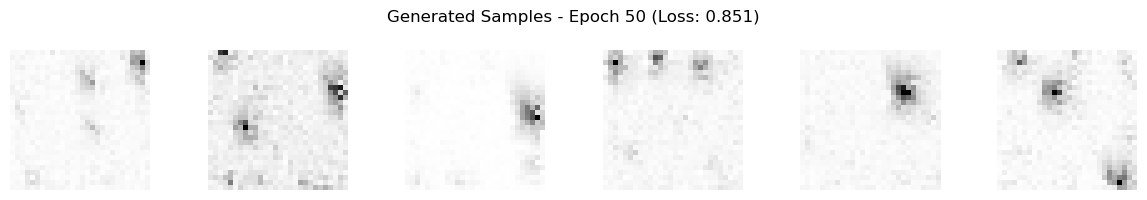

Checkpoint saved: dsm_model_epoch_50.pt


Epoch 51/100: 100%|██████████| 46/46 [00:07<00:00,  6.37it/s, loss=0.8309]


Epoch 51: Loss = 0.8485, LR = 0.000049


Epoch 52/100: 100%|██████████| 46/46 [00:07<00:00,  6.55it/s, loss=0.8168]


Epoch 52: Loss = 0.8495, LR = 0.000047


Epoch 53/100: 100%|██████████| 46/46 [00:06<00:00,  6.60it/s, loss=0.8027]


Epoch 53: Loss = 0.8497, LR = 0.000046


Epoch 54/100: 100%|██████████| 46/46 [00:07<00:00,  6.51it/s, loss=0.8814]


Epoch 54: Loss = 0.8516, LR = 0.000044


Epoch 55/100: 100%|██████████| 46/46 [00:07<00:00,  6.50it/s, loss=0.8198]


Epoch 55: Loss = 0.8508, LR = 0.000043


Epoch 56/100: 100%|██████████| 46/46 [00:07<00:00,  6.56it/s, loss=0.8208]


Epoch 56: Loss = 0.8498, LR = 0.000041


Epoch 57/100: 100%|██████████| 46/46 [00:07<00:00,  6.37it/s, loss=0.8900]


Epoch 57: Loss = 0.8446, LR = 0.000040


Epoch 58/100: 100%|██████████| 46/46 [00:07<00:00,  6.52it/s, loss=0.9065]


Epoch 58: Loss = 0.8526, LR = 0.000038


Epoch 59/100: 100%|██████████| 46/46 [00:07<00:00,  6.41it/s, loss=0.8326]


Epoch 59: Loss = 0.8492, LR = 0.000037


Epoch 60/100: 100%|██████████| 46/46 [00:06<00:00,  6.62it/s, loss=0.8773]


Epoch 60: Loss = 0.8466, LR = 0.000035
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16
 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


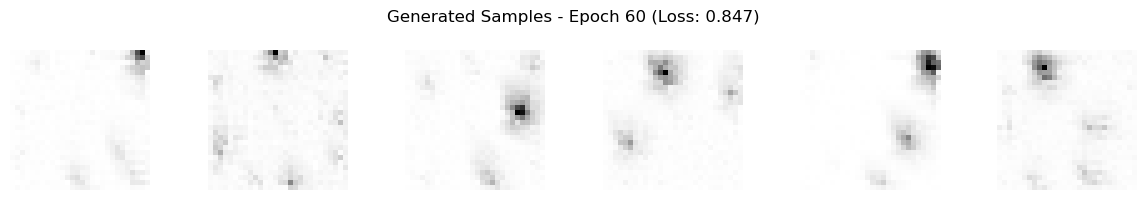

Epoch 61/100: 100%|██████████| 46/46 [00:07<00:00,  6.52it/s, loss=0.8332]


Epoch 61: Loss = 0.8429, LR = 0.000034


Epoch 62/100: 100%|██████████| 46/46 [00:06<00:00,  6.63it/s, loss=0.8541]


Epoch 62: Loss = 0.8438, LR = 0.000032


Epoch 63/100: 100%|██████████| 46/46 [00:07<00:00,  6.53it/s, loss=0.8132]


Epoch 63: Loss = 0.8453, LR = 0.000031


Epoch 64/100: 100%|██████████| 46/46 [00:06<00:00,  6.60it/s, loss=0.8541]


Epoch 64: Loss = 0.8449, LR = 0.000029


Epoch 65/100: 100%|██████████| 46/46 [00:07<00:00,  6.50it/s, loss=0.8534]


Epoch 65: Loss = 0.8453, LR = 0.000028


Epoch 66/100: 100%|██████████| 46/46 [00:07<00:00,  6.47it/s, loss=0.8051]


Epoch 66: Loss = 0.8471, LR = 0.000027


Epoch 67/100: 100%|██████████| 46/46 [00:07<00:00,  6.52it/s, loss=0.8827]


Epoch 67: Loss = 0.8452, LR = 0.000025


Epoch 68/100: 100%|██████████| 46/46 [00:07<00:00,  6.30it/s, loss=0.8137]


Epoch 68: Loss = 0.8458, LR = 0.000024


Epoch 69/100: 100%|██████████| 46/46 [00:07<00:00,  6.54it/s, loss=0.8468]


Epoch 69: Loss = 0.8418, LR = 0.000023


Epoch 70/100: 100%|██████████| 46/46 [00:07<00:00,  6.20it/s, loss=0.8508]


Epoch 70: Loss = 0.8430, LR = 0.000021
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16
 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


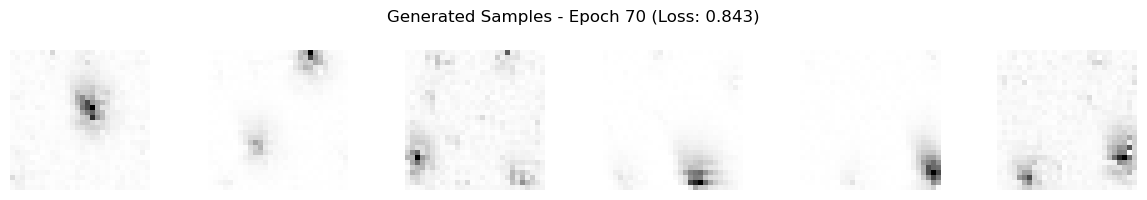

Epoch 71/100: 100%|██████████| 46/46 [00:07<00:00,  6.49it/s, loss=0.8294]


Epoch 71: Loss = 0.8403, LR = 0.000020


Epoch 72/100: 100%|██████████| 46/46 [00:07<00:00,  6.41it/s, loss=0.8250]


Epoch 72: Loss = 0.8452, LR = 0.000019


Epoch 73/100: 100%|██████████| 46/46 [00:07<00:00,  6.51it/s, loss=0.8877]


Epoch 73: Loss = 0.8434, LR = 0.000018


Epoch 74/100: 100%|██████████| 46/46 [00:07<00:00,  6.51it/s, loss=0.8367]


Epoch 74: Loss = 0.8480, LR = 0.000017


Epoch 75/100: 100%|██████████| 46/46 [00:07<00:00,  5.83it/s, loss=0.8934]


Epoch 75: Loss = 0.8438, LR = 0.000015


Epoch 76/100: 100%|██████████| 46/46 [00:07<00:00,  6.52it/s, loss=0.8382]


Epoch 76: Loss = 0.8455, LR = 0.000014


Epoch 77/100: 100%|██████████| 46/46 [00:06<00:00,  6.65it/s, loss=0.8457]


Epoch 77: Loss = 0.8452, LR = 0.000013


Epoch 78/100: 100%|██████████| 46/46 [00:07<00:00,  6.50it/s, loss=0.8263]


Epoch 78: Loss = 0.8432, LR = 0.000012


Epoch 79/100: 100%|██████████| 46/46 [00:07<00:00,  6.50it/s, loss=0.8332]


Epoch 79: Loss = 0.8420, LR = 0.000011


Epoch 80/100: 100%|██████████| 46/46 [00:07<00:00,  6.57it/s, loss=0.8566]


Epoch 80: Loss = 0.8377, LR = 0.000010
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16
 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


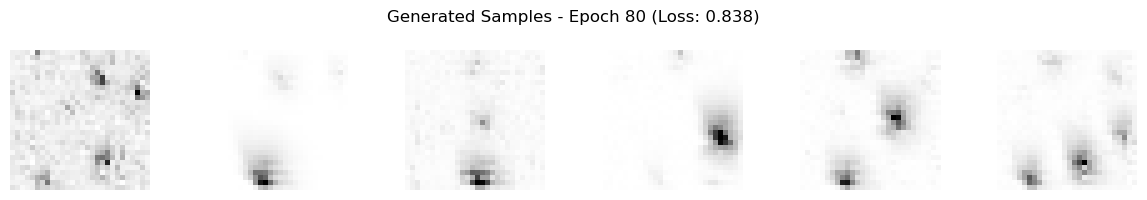

Epoch 81/100: 100%|██████████| 46/46 [00:07<00:00,  6.53it/s, loss=0.8652]


Epoch 81: Loss = 0.8379, LR = 0.000010


Epoch 82/100: 100%|██████████| 46/46 [00:07<00:00,  6.53it/s, loss=0.8179]


Epoch 82: Loss = 0.8433, LR = 0.000009


Epoch 83/100: 100%|██████████| 46/46 [00:06<00:00,  6.64it/s, loss=0.8757]


Epoch 83: Loss = 0.8419, LR = 0.000008


Epoch 84/100: 100%|██████████| 46/46 [00:07<00:00,  6.44it/s, loss=0.8283]


Epoch 84: Loss = 0.8426, LR = 0.000007


Epoch 85/100: 100%|██████████| 46/46 [00:07<00:00,  6.51it/s, loss=0.7931]


Epoch 85: Loss = 0.8421, LR = 0.000006


Epoch 86/100: 100%|██████████| 46/46 [00:08<00:00,  5.54it/s, loss=0.8381]


Epoch 86: Loss = 0.8447, LR = 0.000006


Epoch 87/100: 100%|██████████| 46/46 [00:07<00:00,  5.94it/s, loss=0.8614]


Epoch 87: Loss = 0.8396, LR = 0.000005


Epoch 88/100: 100%|██████████| 46/46 [00:08<00:00,  5.34it/s, loss=0.8640]


Epoch 88: Loss = 0.8437, LR = 0.000004


Epoch 89/100: 100%|██████████| 46/46 [00:08<00:00,  5.51it/s, loss=0.8302]


Epoch 89: Loss = 0.8396, LR = 0.000004


Epoch 90/100: 100%|██████████| 46/46 [00:07<00:00,  6.19it/s, loss=0.8501]


Epoch 90: Loss = 0.8405, LR = 0.000003
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16
 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


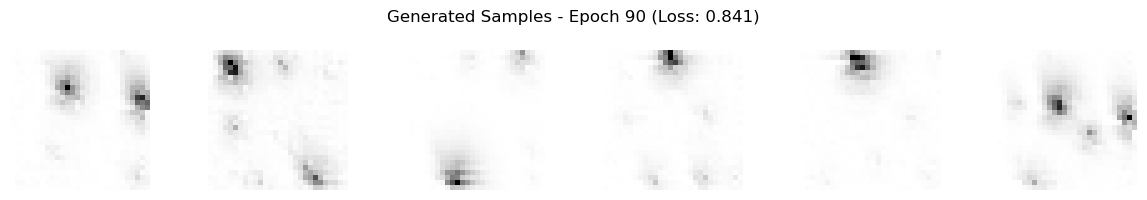

Epoch 91/100: 100%|██████████| 46/46 [00:07<00:00,  6.14it/s, loss=0.8623]


Epoch 91: Loss = 0.8412, LR = 0.000003


Epoch 92/100: 100%|██████████| 46/46 [00:07<00:00,  6.17it/s, loss=0.8779]


Epoch 92: Loss = 0.8459, LR = 0.000003


Epoch 93/100: 100%|██████████| 46/46 [00:07<00:00,  6.13it/s, loss=0.8125]


Epoch 93: Loss = 0.8441, LR = 0.000002


Epoch 94/100: 100%|██████████| 46/46 [00:07<00:00,  6.24it/s, loss=0.8356]


Epoch 94: Loss = 0.8399, LR = 0.000002


Epoch 95/100: 100%|██████████| 46/46 [00:07<00:00,  6.17it/s, loss=0.8511]


Epoch 95: Loss = 0.8443, LR = 0.000002


Epoch 96/100: 100%|██████████| 46/46 [00:07<00:00,  6.23it/s, loss=0.8376]


Epoch 96: Loss = 0.8367, LR = 0.000001


Epoch 97/100: 100%|██████████| 46/46 [00:07<00:00,  6.12it/s, loss=0.8689]


Epoch 97: Loss = 0.8456, LR = 0.000001


Epoch 98/100: 100%|██████████| 46/46 [00:07<00:00,  5.97it/s, loss=0.8216]


Epoch 98: Loss = 0.8424, LR = 0.000001


Epoch 99/100: 100%|██████████| 46/46 [00:08<00:00,  5.73it/s, loss=0.8307]


Epoch 99: Loss = 0.8421, LR = 0.000001


Epoch 100/100: 100%|██████████| 46/46 [00:07<00:00,  6.28it/s, loss=0.8023]

Epoch 100: Loss = 0.8411, LR = 0.000001
Generating samples...
 Step 1/1000, t=1.0000, noise SD=3.16


 Step 200/1000, t=0.8010, noise SD=2.83
 Step 400/1000, t=0.6010, noise SD=2.46
 Step 600/1000, t=0.4010, noise SD=2.02
 Step 800/1000, t=0.2010, noise SD=1.45


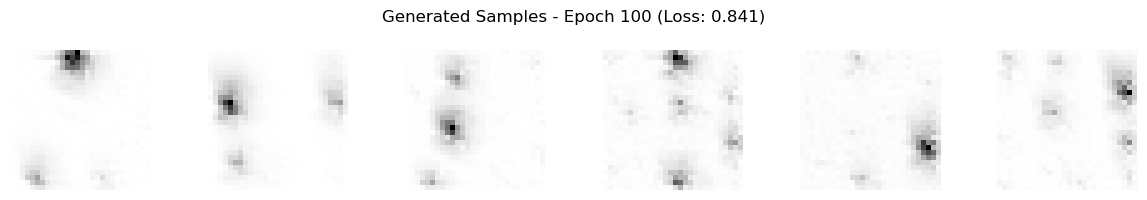

Checkpoint saved: dsm_model_epoch_100.pt


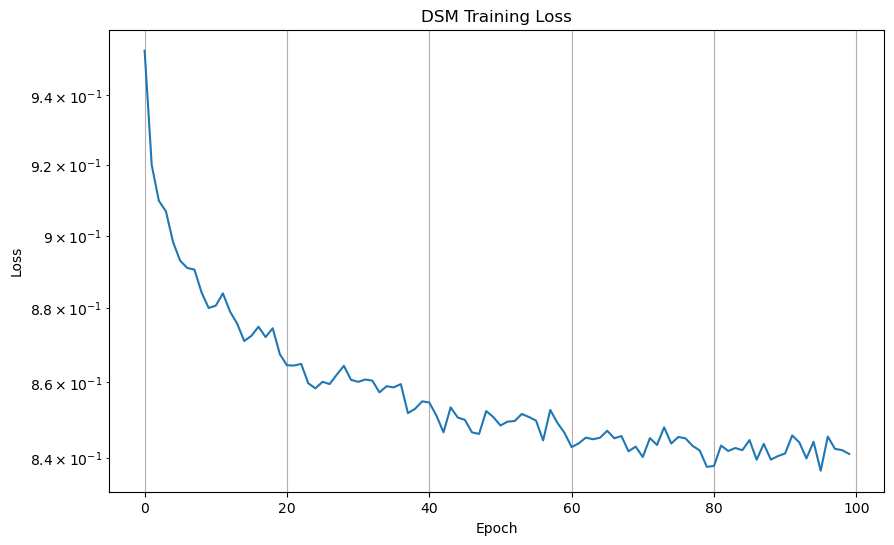

(ScoreNet(
   (net): Sequential(
     (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): SiLU()
     (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): SiLU()
     (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): SiLU()
     (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (11): SiLU()
     (12): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (14): SiLU()
     (15): Conv2d(128, 64, kernel_size=(

In [18]:
train_score_model(model, train_loader, device, num_epochs = 100)

### Question: _What do you observe as the training progresses?_
*  We can see  that the training loss curve decreased from ~0.95 to ~0.84 a the training result is improving continuously
*  For the generate samples we can see from the beginning, most of the part are blurry noise and some localize stroke could be see arond 40-50 epoches
*  and the strokes are more clear at 80-100 epoches, we can see our model is learning the  manifold of digit 8 images whole some details are still missing.
*  We can the image are getting more smoother and have less ramdom noise.